In [61]:
from diffusers import AutoPipelineForText2Image
import torch
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


# Load the model
pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/sd-turbo", torch_dtype=torch.float16).to("cuda")

# Check that the file exists
path = Path("../models/sd_lora/sd_lora_output")
assert path.exists(), "File not found"

# Load the textual inversion embeddings
pipeline.load_lora_weights(path, weight_name="pytorch_lora_weights.safetensors")

image_list = []
for i in range(9):
    image_list.append(
        pipeline("A healthy cardiac image from a Samsung ultrasound machine.", 
                                num_inference_steps=100,
                                # guidance_rescale=0.0,
                                ).images[0]
        )

Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 100/100 [00:10<00:00,  9.78it/s]


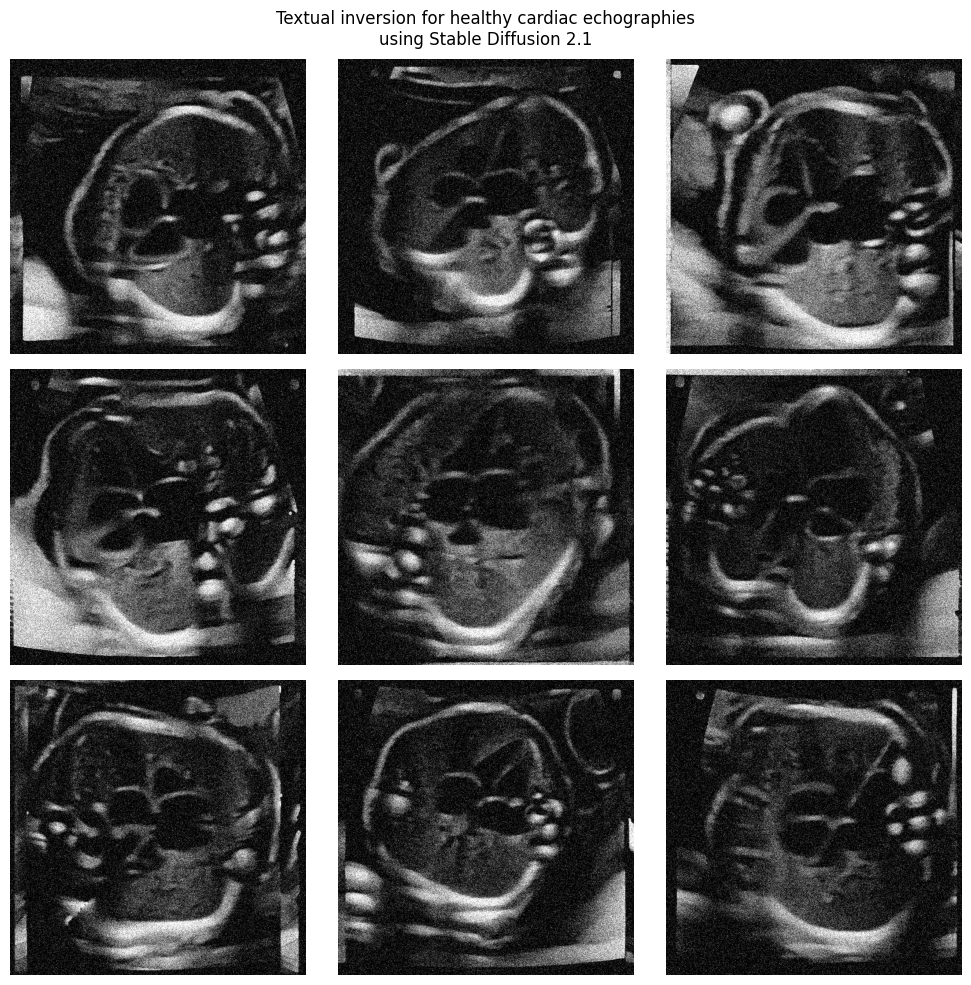

In [71]:
# Add speckle noise to the images to improve realism
def add_speckle_noise(image, mean=0, std=0.15, patch_size=256):
    """Adds more realistic speckle noise to an image with larger areas.

    Args:
        image: A PyTorch tensor of shape (C, H, W) representing the image.
        mean: The mean of the Gaussian distribution for generating noise.
        std: The standard deviation of the Gaussian distribution.
        patch_size: Size of the patches for applying localized noise (larger for bigger areas).

    Returns:
        A PyTorch tensor of the same shape as the input image with more realistic speckle noise.
    """

    # Generate Gaussian noise with low std for overall noise
    base_noise = torch.randn(image.shape, device=image.device) * 0.05 + mean

    # Generate additional localized noise with higher std and larger patches
    patch_noise = torch.zeros_like(image)
    for i in range(0, image.shape[1], patch_size):
        for j in range(0, image.shape[2], patch_size):
            patch_noise[:, i:i+patch_size, j:j+patch_size] = torch.randn(patch_size, patch_size, device=image.device) * std + mean

    # Combine both noise components
    noisy_image = image + image * base_noise + patch_noise

    # Clamp the noisy image values to the valid range [0, 1]
    noisy_image = torch.clamp(noisy_image, 0, 1)

    return noisy_image

noisy_images = [
    add_speckle_noise(
        transforms.ToTensor()(
            transforms.Grayscale()(image)
            )
        ) 
    for image in image_list]

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")
fig.suptitle("Textual inversion for healthy cardiac echographies\nusing Stable Diffusion 2.1")
plt.tight_layout()
plt.show()